## RandAugmentation_vanila
- baseline code가 존재하는 디렉토리에 해당 노트북을 다운받아 실행해주시기바랍니다.

In [1]:
import torch
import os
import sys
import yaml
from torchvision import transforms
from torchvision.datasets import CIFAR10
from typing import Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

if "./" not in sys.path:
    sys.path.append("./")

In [2]:
# load dataset
from src.dataloader import create_dataloader

dataset_info_path = './configs/data/taco.yaml'
with open(dataset_info_path,'r') as f:
    cfg = yaml.load(f,Loader=yaml.SafeLoader)
print(cfg)

train_dataset, val_dataset, test_dataset,batch_size = create_dataloader(cfg,want_dataset=True)
print(len(train_dataset),len(val_dataset),len(test_dataset),batch_size)


{'DATA_PATH': '/opt/ml/data/', 'DATASET': 'TACO', 'IMG_SIZE': 224, 'AUG_TRAIN': 'simple_augment_train', 'AUG_TEST': 'simple_augment_test', 'AUG_TRAIN_PARAMS': None, 'BATCH_SIZE': 64, 'EPOCHS': 100, 'VAL_RATIO': 0.0, 'INIT_LR': 0.1, 'FP16': True}
15640 5211 5217 64


In [5]:
#function for visualization

MEAN_V = (0.4914, 0.4822, 0.4465)
STD_V = (0.2470, 0.2435, 0.2616)

def tensor_to_img(tensor_img: torch.Tensor) -> np.ndarray:
    return ((tensor_img.permute(1, 2, 0).numpy() * STD_V + MEAN_V) * 255).astype(np.uint8)

def visualize_datasets(_train_dataset: CIFAR10, _val_dataset: CIFAR10, _test_dataset: CIFAR10, title_prefix: str = "") -> None:
    fig, ax = plt.subplots(3, 7, figsize=(20, 10))

    for i in range(7):
        idx = np.random.randint(0, len(val_dataset))

        ax[0][i].imshow(tensor_to_img(_train_dataset[idx][0]))
        ax[1][i].imshow(tensor_to_img(_val_dataset[idx][0]))
        ax[2][i].imshow(tensor_to_img(_test_dataset[idx][0]))

        ax[0][i].axis('off')
        ax[1][i].axis('off')
        ax[2][i].axis('off')

    fig.suptitle(f"{title_prefix} Visualization of Augmentation.\n(Each row represents train, validation, test dataset accordingly)")
    fig.show()

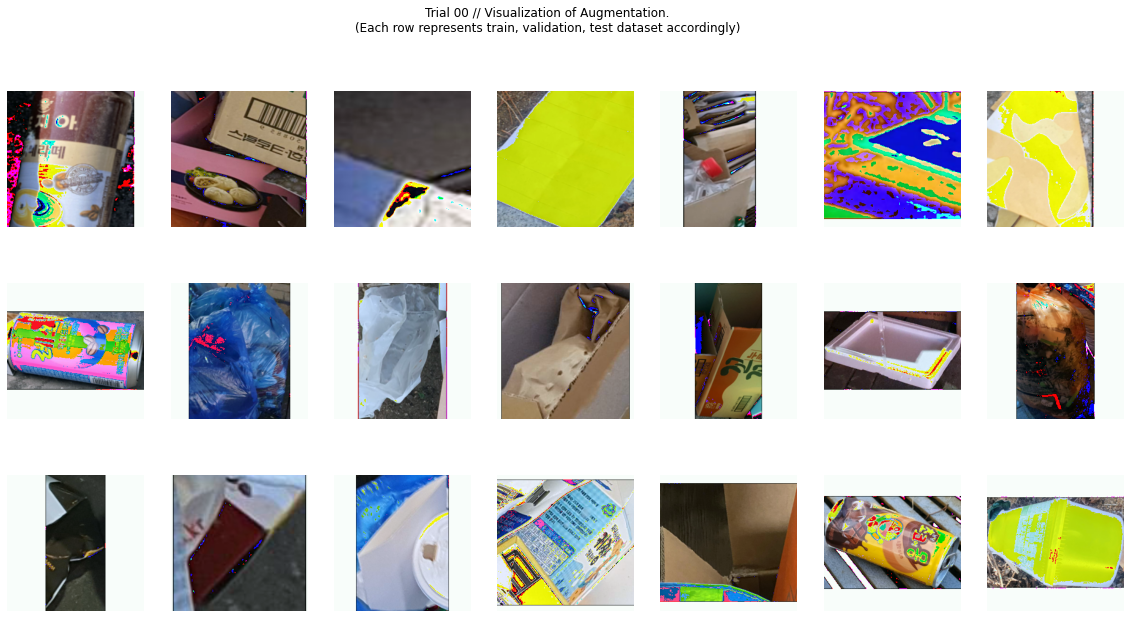

In [6]:
#visualize loaded dataset
visualize_datasets(train_dataset, val_dataset, test_dataset, title_prefix="Trial 00 //")

In [7]:
#load model from yaml
from src.model import Model

with open("./configs/model/mobilenetv3.yaml", "r") as f:
    model_cfg = yaml.load(f, yaml.SafeLoader)

model_cfg['backbone'][-1][-1] = [10]

model = Model(model_cfg, verbose=True)

idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           40           80
  8 |   1 |     34,760 | InvertedResidual

In [8]:
#train model
from src.trainer import TorchTrainer
from src.loss import CustomCriterion
from src.dataloader import get_dataloader

EPOCHS = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

optimizer = torch.optim.SGD(model.model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=0.1, steps_per_epoch=len(train_dataset), epochs=EPOCHS, pct_start=0.05)
criterion = CustomCriterion(samples_per_cls=None, device=device)

#load dataloader
train_loader,val_loader,test_loader = get_dataloader(train_dataset, val_dataset, test_dataset,batch_size)

exp_dir = "./exp/exp2"
os.makedirs(exp_dir, exist_ok=True)
trainer = TorchTrainer(model=model, 
                       criterion=criterion, 
                       optimizer=optimizer, 
                       scheduler=scheduler, 
                       device=device, 
                       verbose=1, 
                       model_path=os.path.join(exp_dir, "best.pt"))

best_acc, best_f1 = trainer.train(train_dataloader=train_loader, 
                                  n_epoch=EPOCHS, 
                                  val_dataloader=val_loader)

Train: [001] Loss: 2.449, Acc: 3.12% F1(macro): 0.04:   0%|          | 0/244 [00:02<?, ?it/s]        


AttributeError: 'NoneType' object has no attribute 'number'

In [9]:
test_loss, test_f1, test_accuracy = trainer.test(model, test_loader)

 Val:       Loss: 1.310, Acc: 55.50% F1(macro): 0.53: 100%|██████████| 79/79 [00:01<00:00, 43.17it/s]


Optuna 이용

In [11]:
import optuna
#from src.trainer import TorchTrainer
#from src.loss import CustomCriterion
#from src.model import Model
from torch.utils.data import DataLoader, random_split

In [22]:
MEAN_V = (0.4914, 0.4822, 0.4465)
STD_V = (0.2470, 0.2435, 0.2616)
DATASET_DIR = "./input/cifar10"

#transform 리스트 생성
def generate_transform(resize: int = 32, aug_fcns: Tuple = ()) -> transforms.transforms.Compose:
    """Generate train augmentation policy."""
    transform_fcns = []
    transform_fcns.append(transforms.Resize((resize, resize)))
    transform_fcns += list(aug_fcns)
    
    transform_fcns.append(transforms.ToTensor())
    transform_fcns.append(transforms.Normalize(MEAN_V, STD_V))
    
    return transforms.Compose(transform_fcns)

#dataset 로드
def load_cifar10(img_size: int = 32, 
                 aug_fcns: Tuple = (), 
                 validation_ratio: float = 0.8,
                ) -> Tuple[CIFAR10, CIFAR10, CIFAR10]:
    tf_train = generate_transform(resize=img_size, aug_fcns=aug_fcns)
    tf_test = generate_transform(resize=img_size)
    
    train_dataset = CIFAR10(root=DATASET_DIR, train=True, download=True, transform=tf_train)
    train_length = int(len(train_dataset) * validation_ratio)
    val_length = len(train_dataset) - train_length

    train_dataset, val_dataset = random_split(train_dataset, [train_length, val_length])
    test_dataset = CIFAR10(root=DATASET_DIR, train=False, download=True, transform=tf_test)
    
    return train_dataset, val_dataset, test_dataset

In [23]:

def objective(trial:optuna.Trial,model_cfg) -> float:
    img_size = 32
    #transform 정의 - trial에 추가
    augmentation_functions = []
    use_color_jitter = trial.suggest_categorical("aug_color_jitter", [True, False])
    use_random_perspective = trial.suggest_categorical("aug_random_perspective", [True, False])
    use_random_flip = trial.suggest_categorical("aug_random_flip", [True, False])
    
    if use_color_jitter:
        augmentation_functions.append(transforms.ColorJitter(brightness=(0.5, 1.5), 
                                                             contrast=(0.5, 1.5), 
                                                             saturation=(0.5, 1.5)))
    if use_random_perspective:
        augmentation_functions.append(transforms.RandomPerspective())
    if use_random_flip:
        augmentation_functions.append(transforms.RandomHorizontalFlip())
    
    #loadd dataset
    train_dataset, val_dataset, test_dataset = load_cifar10(img_size=img_size, 
                                                            aug_fcns = tuple(augmentation_functions), 
                                                            validation_ratio=0.8)
    #visualize
    visualize_datasets(train_dataset, val_dataset, test_dataset, title_prefix=f"Trial {trial.number:03d} //")
    plt.draw()
    plt.show()
    print(augmentation_functions)

    #trial마다 모델 정의
    model = Model(model_cfg, verbose=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    #optimizer, scheduler, loss
    optimizer = torch.optim.SGD(model.model.parameters(), lr=0.1, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=0.1, steps_per_epoch=len(train_dataset), epochs=EPOCHS, pct_start=0.05)
    criterion = CustomCriterion(samples_per_cls=None, device=device)

    #load dataloader
    train_loader,val_loader,test_loader = get_dataloader(train_dataset, val_dataset, test_dataset,batch_size)
    #set save dir
    exp_dir = "./exp/autoaug"
    os.makedirs(exp_dir, exist_ok=True)
    #train
    trainer = TorchTrainer(model=model, 
                           criterion=criterion, 
                           optimizer=optimizer, 
                           scheduler=scheduler, 
                           device=device, 
                           verbose=1, 
                           model_path=os.path.join(exp_dir, "best.pt"))

    best_acc, best_f1 = trainer.train(train_dataloader=train_loader, 
                                      n_epoch=EPOCHS, 
                                      val_dataloader=val_loader)
    #test
    print("TEST DATASET")
    test_loss, test_f1, test_accuracy = trainer.test(model, test_loader)
    
    return test_f1
    #set save dir

[I 2021-11-24 07:38:36,808] A new study created in memory with name: autoaug


Files already downloaded and verified
Files already downloaded and verified


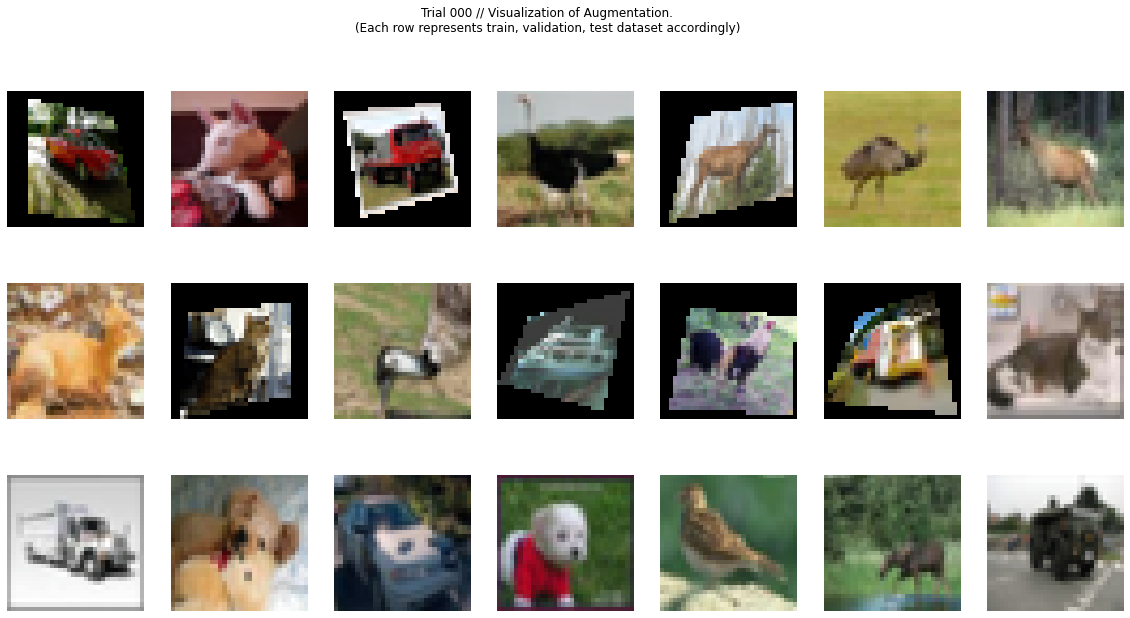

[RandomPerspective(p=0.5), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           4

Train: [001] Loss: 1.970, Acc: 27.47% F1(macro): 0.27: 100%|██████████| 312/312 [00:21<00:00, 14.70it/s]
 Val:       Loss: 1.697, Acc: 36.88% F1(macro): 0.35: 100%|██████████| 79/79 [00:01<00:00, 42.83it/s]


Model saved. Current best test f1: 0.347


Train: [002] Loss: 1.657, Acc: 40.30% F1(macro): 0.40: 100%|██████████| 312/312 [00:20<00:00, 14.91it/s]
 Val:       Loss: 1.723, Acc: 39.66% F1(macro): 0.38: 100%|██████████| 79/79 [00:01<00:00, 42.74it/s]


Model saved. Current best test f1: 0.377


Train: [003] Loss: 1.601, Acc: 42.54% F1(macro): 0.42: 100%|██████████| 312/312 [00:21<00:00, 14.58it/s]
 Val:       Loss: 1.581, Acc: 43.02% F1(macro): 0.40: 100%|██████████| 79/79 [00:01<00:00, 44.65it/s]


Model saved. Current best test f1: 0.401


Train: [004] Loss: 1.481, Acc: 46.64% F1(macro): 0.46: 100%|██████████| 312/312 [00:21<00:00, 14.60it/s]
 Val:       Loss: 1.428, Acc: 48.20% F1(macro): 0.47: 100%|██████████| 79/79 [00:01<00:00, 42.51it/s]


Model saved. Current best test f1: 0.466


Train: [005] Loss: 1.378, Acc: 50.37% F1(macro): 0.50: 100%|██████████| 312/312 [00:21<00:00, 14.80it/s]
 Val:       Loss: 1.376, Acc: 51.80% F1(macro): 0.51: 100%|██████████| 79/79 [00:01<00:00, 42.09it/s]


Model saved. Current best test f1: 0.511


Train: [006] Loss: 1.327, Acc: 52.38% F1(macro): 0.52: 100%|██████████| 312/312 [00:21<00:00, 14.26it/s]
 Val:       Loss: 1.338, Acc: 52.23% F1(macro): 0.52: 100%|██████████| 79/79 [00:01<00:00, 43.28it/s]


Model saved. Current best test f1: 0.521


Train: [007] Loss: 1.340, Acc: 52.57% F1(macro): 0.52: 100%|██████████| 312/312 [00:21<00:00, 14.67it/s]
 Val:       Loss: 1.384, Acc: 50.51% F1(macro): 0.50: 100%|██████████| 79/79 [00:01<00:00, 43.97it/s]
Train: [008] Loss: 1.295, Acc: 53.64% F1(macro): 0.53: 100%|██████████| 312/312 [00:21<00:00, 14.39it/s]
 Val:       Loss: 1.228, Acc: 55.39% F1(macro): 0.55: 100%|██████████| 79/79 [00:01<00:00, 45.46it/s]


Model saved. Current best test f1: 0.553


Train: [009] Loss: 1.231, Acc: 56.05% F1(macro): 0.56: 100%|██████████| 312/312 [00:21<00:00, 14.59it/s]
 Val:       Loss: 1.341, Acc: 51.68% F1(macro): 0.51: 100%|██████████| 79/79 [00:01<00:00, 39.78it/s]
Train: [010] Loss: 1.264, Acc: 54.71% F1(macro): 0.54: 100%|██████████| 312/312 [00:21<00:00, 14.50it/s]
 Val:       Loss: 1.204, Acc: 56.44% F1(macro): 0.56: 100%|██████████| 79/79 [00:01<00:00, 43.76it/s]


Model saved. Current best test f1: 0.561
TEST DATASET


 Val:       Loss: 1.097, Acc: 61.55% F1(macro): 0.61: 100%|██████████| 79/79 [00:01<00:00, 45.59it/s]
[I 2021-11-24 07:42:48,994] Trial 0 finished with value: 0.6130165638979886 and parameters: {'aug_color_jitter': False, 'aug_random_perspective': True, 'aug_random_flip': True}. Best is trial 0 with value: 0.6130165638979886.


Files already downloaded and verified
Files already downloaded and verified


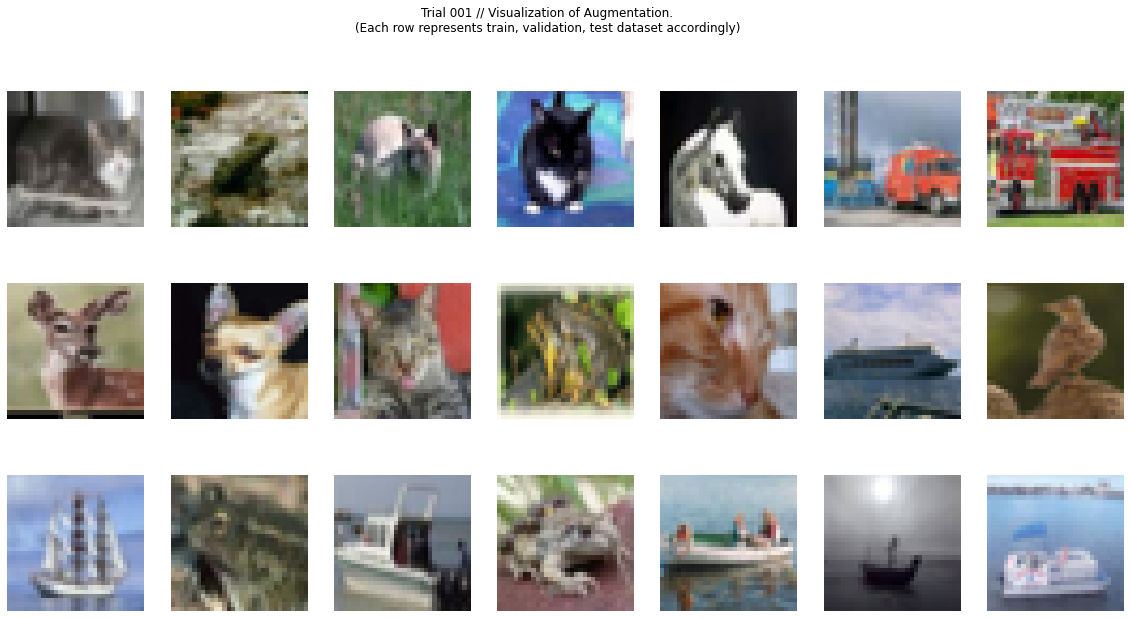

[]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           40           80
  8 |   1 |     34,760 | InvertedResid

Train: [001] Loss: 1.814, Acc: 33.69% F1(macro): 0.33: 100%|██████████| 312/312 [00:21<00:00, 14.60it/s]
 Val:       Loss: 1.522, Acc: 44.61% F1(macro): 0.45: 100%|██████████| 79/79 [00:01<00:00, 44.73it/s]


Model saved. Current best test f1: 0.445


Train: [002] Loss: 1.423, Acc: 48.44% F1(macro): 0.48: 100%|██████████| 312/312 [00:21<00:00, 14.74it/s]
 Val:       Loss: 1.408, Acc: 48.84% F1(macro): 0.49: 100%|██████████| 79/79 [00:01<00:00, 45.46it/s]


Model saved. Current best test f1: 0.487


Train: [003] Loss: 1.286, Acc: 53.85% F1(macro): 0.54: 100%|██████████| 312/312 [00:21<00:00, 14.55it/s]
 Val:       Loss: 1.246, Acc: 54.94% F1(macro): 0.54: 100%|██████████| 79/79 [00:01<00:00, 44.88it/s]


Model saved. Current best test f1: 0.541


Train: [004] Loss: 1.173, Acc: 57.86% F1(macro): 0.58: 100%|██████████| 312/312 [00:21<00:00, 14.58it/s]
 Val:       Loss: 1.250, Acc: 55.54% F1(macro): 0.55: 100%|██████████| 79/79 [00:01<00:00, 44.08it/s]


Model saved. Current best test f1: 0.546


Train: [005] Loss: 1.085, Acc: 61.60% F1(macro): 0.61: 100%|██████████| 312/312 [00:21<00:00, 14.50it/s]
 Val:       Loss: 1.140, Acc: 59.32% F1(macro): 0.59: 100%|██████████| 79/79 [00:01<00:00, 45.82it/s]


Model saved. Current best test f1: 0.593


Train: [006] Loss: 1.013, Acc: 64.39% F1(macro): 0.64: 100%|██████████| 312/312 [00:21<00:00, 14.61it/s]
 Val:       Loss: 1.113, Acc: 60.99% F1(macro): 0.61: 100%|██████████| 79/79 [00:01<00:00, 45.21it/s]


Model saved. Current best test f1: 0.607


Train: [007] Loss: 1.012, Acc: 64.56% F1(macro): 0.64: 100%|██████████| 312/312 [00:21<00:00, 14.61it/s]
 Val:       Loss: 1.122, Acc: 61.43% F1(macro): 0.61: 100%|██████████| 79/79 [00:01<00:00, 41.70it/s]


Model saved. Current best test f1: 0.613


Train: [008] Loss: 0.986, Acc: 65.41% F1(macro): 0.65: 100%|██████████| 312/312 [00:22<00:00, 14.02it/s]
 Val:       Loss: 0.987, Acc: 64.40% F1(macro): 0.64: 100%|██████████| 79/79 [00:01<00:00, 43.64it/s]


Model saved. Current best test f1: 0.642


Train: [009] Loss: 0.972, Acc: 65.93% F1(macro): 0.66: 100%|██████████| 312/312 [00:23<00:00, 13.55it/s]
 Val:       Loss: 1.273, Acc: 59.98% F1(macro): 0.59: 100%|██████████| 79/79 [00:02<00:00, 39.25it/s]
Train: [010] Loss: 1.101, Acc: 62.36% F1(macro): 0.62: 100%|██████████| 312/312 [00:23<00:00, 13.45it/s]
 Val:       Loss: 1.054, Acc: 62.80% F1(macro): 0.63: 100%|██████████| 79/79 [00:01<00:00, 40.00it/s]


TEST DATASET


 Val:       Loss: 1.051, Acc: 62.74% F1(macro): 0.63: 100%|██████████| 79/79 [00:01<00:00, 42.37it/s]
[I 2021-11-24 07:47:05,523] Trial 1 finished with value: 0.6316312947317301 and parameters: {'aug_color_jitter': False, 'aug_random_perspective': False, 'aug_random_flip': False}. Best is trial 1 with value: 0.6316312947317301.


Files already downloaded and verified
Files already downloaded and verified


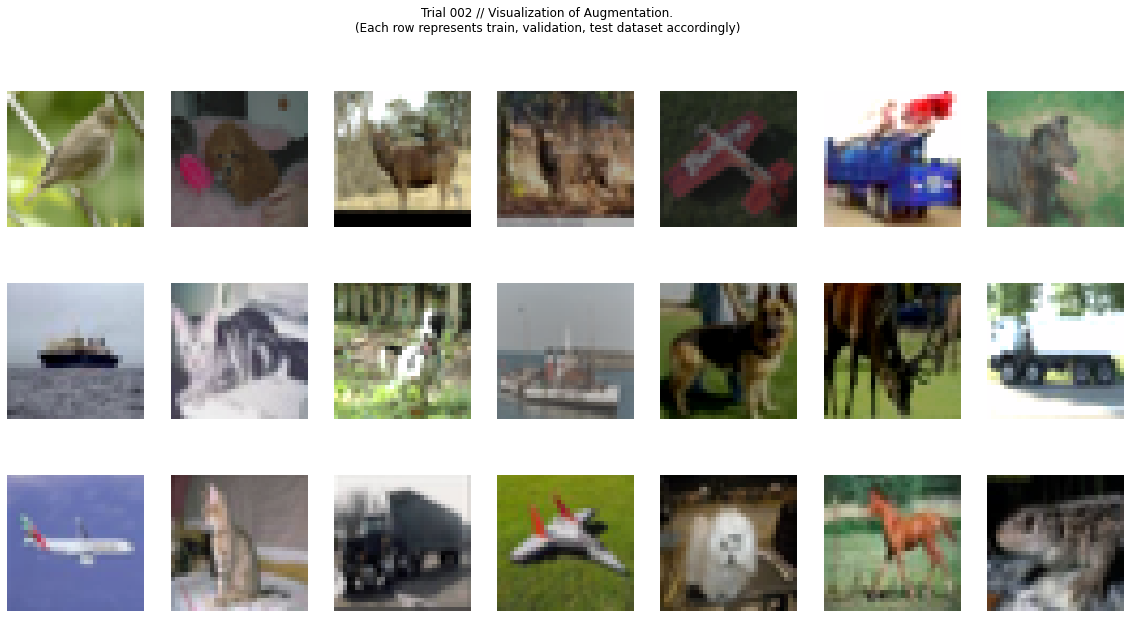

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     

Train: [001] Loss: 1.943, Acc: 28.42% F1(macro): 0.28: 100%|██████████| 312/312 [00:22<00:00, 13.61it/s]
 Val:       Loss: 1.727, Acc: 36.23% F1(macro): 0.33: 100%|██████████| 79/79 [00:02<00:00, 37.65it/s]


Model saved. Current best test f1: 0.330


Train: [002] Loss: 1.607, Acc: 41.29% F1(macro): 0.41: 100%|██████████| 312/312 [00:23<00:00, 13.27it/s]
 Val:       Loss: 1.553, Acc: 44.87% F1(macro): 0.44: 100%|██████████| 79/79 [00:02<00:00, 35.95it/s]


Model saved. Current best test f1: 0.440


Train: [003] Loss: 1.490, Acc: 46.37% F1(macro): 0.46: 100%|██████████| 312/312 [00:23<00:00, 13.12it/s]
 Val:       Loss: 1.452, Acc: 48.00% F1(macro): 0.47: 100%|██████████| 79/79 [00:02<00:00, 37.66it/s]


Model saved. Current best test f1: 0.474


Train: [004] Loss: 1.414, Acc: 49.38% F1(macro): 0.49: 100%|██████████| 312/312 [00:22<00:00, 13.59it/s]
 Val:       Loss: 1.372, Acc: 50.49% F1(macro): 0.49: 100%|██████████| 79/79 [00:02<00:00, 38.39it/s]


Model saved. Current best test f1: 0.490


Train: [005] Loss: 1.315, Acc: 53.04% F1(macro): 0.53: 100%|██████████| 312/312 [00:23<00:00, 13.33it/s]
 Val:       Loss: 1.287, Acc: 53.95% F1(macro): 0.53: 100%|██████████| 79/79 [00:02<00:00, 36.25it/s]


Model saved. Current best test f1: 0.535


Train: [006] Loss: 1.220, Acc: 56.67% F1(macro): 0.56: 100%|██████████| 312/312 [00:22<00:00, 13.66it/s]
 Val:       Loss: 1.207, Acc: 56.79% F1(macro): 0.56: 100%|██████████| 79/79 [00:02<00:00, 35.36it/s]


Model saved. Current best test f1: 0.564


Train: [007] Loss: 1.140, Acc: 59.58% F1(macro): 0.59: 100%|██████████| 312/312 [00:23<00:00, 13.25it/s]
 Val:       Loss: 1.147, Acc: 59.35% F1(macro): 0.60: 100%|██████████| 79/79 [00:02<00:00, 37.45it/s]


Model saved. Current best test f1: 0.597


Train: [008] Loss: 1.081, Acc: 61.80% F1(macro): 0.62: 100%|██████████| 312/312 [00:23<00:00, 13.41it/s]
 Val:       Loss: 1.096, Acc: 61.75% F1(macro): 0.61: 100%|██████████| 79/79 [00:02<00:00, 37.91it/s]


Model saved. Current best test f1: 0.613


Train: [009] Loss: 1.090, Acc: 61.78% F1(macro): 0.62: 100%|██████████| 312/312 [00:23<00:00, 13.23it/s]
 Val:       Loss: 1.088, Acc: 61.53% F1(macro): 0.62: 100%|██████████| 79/79 [00:02<00:00, 36.87it/s]


Model saved. Current best test f1: 0.616


Train: [010] Loss: 1.006, Acc: 64.71% F1(macro): 0.65: 100%|██████████| 312/312 [00:23<00:00, 13.40it/s]
 Val:       Loss: 1.211, Acc: 57.69% F1(macro): 0.58: 100%|██████████| 79/79 [00:02<00:00, 38.38it/s]

TEST DATASET



 Val:       Loss: 1.128, Acc: 60.83% F1(macro): 0.61: 100%|██████████| 79/79 [00:01<00:00, 42.99it/s]
[I 2021-11-24 07:51:40,891] Trial 2 finished with value: 0.6079286540455218 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 1 with value: 0.6316312947317301.


Files already downloaded and verified
Files already downloaded and verified


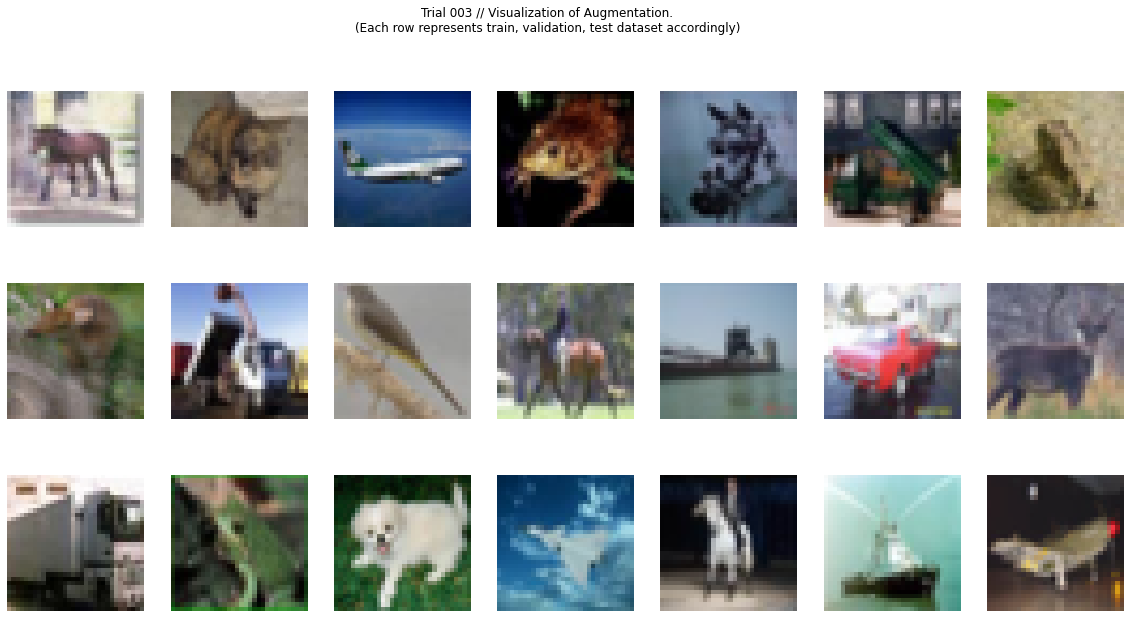

[]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           40           80
  8 |   1 |     34,760 | InvertedResid

Train: [001] Loss: 1.815, Acc: 33.21% F1(macro): 0.33: 100%|██████████| 312/312 [00:22<00:00, 13.79it/s]
 Val:       Loss: 1.581, Acc: 42.24% F1(macro): 0.41: 100%|██████████| 79/79 [00:01<00:00, 41.91it/s]


Model saved. Current best test f1: 0.410


Train: [002] Loss: 1.489, Acc: 46.81% F1(macro): 0.46: 100%|██████████| 312/312 [00:22<00:00, 13.60it/s]
 Val:       Loss: 1.450, Acc: 47.37% F1(macro): 0.47: 100%|██████████| 79/79 [00:01<00:00, 40.96it/s]


Model saved. Current best test f1: 0.474


Train: [003] Loss: 1.344, Acc: 51.79% F1(macro): 0.52: 100%|██████████| 312/312 [00:22<00:00, 14.03it/s]
 Val:       Loss: 1.344, Acc: 51.35% F1(macro): 0.50: 100%|██████████| 79/79 [00:01<00:00, 42.84it/s]


Model saved. Current best test f1: 0.503


Train: [004] Loss: 1.255, Acc: 55.19% F1(macro): 0.55: 100%|██████████| 312/312 [00:22<00:00, 13.86it/s]
 Val:       Loss: 1.267, Acc: 54.42% F1(macro): 0.55: 100%|██████████| 79/79 [00:01<00:00, 40.23it/s]


Model saved. Current best test f1: 0.546


Train: [005] Loss: 1.157, Acc: 58.70% F1(macro): 0.59: 100%|██████████| 312/312 [00:22<00:00, 13.80it/s]
 Val:       Loss: 1.218, Acc: 56.54% F1(macro): 0.56: 100%|██████████| 79/79 [00:01<00:00, 42.02it/s]


Model saved. Current best test f1: 0.559


Train: [006] Loss: 1.095, Acc: 61.06% F1(macro): 0.61: 100%|██████████| 312/312 [00:22<00:00, 13.77it/s]
 Val:       Loss: 1.187, Acc: 58.63% F1(macro): 0.58: 100%|██████████| 79/79 [00:01<00:00, 44.65it/s]


Model saved. Current best test f1: 0.583


Train: [007] Loss: 1.039, Acc: 63.01% F1(macro): 0.63: 100%|██████████| 312/312 [00:22<00:00, 14.00it/s]
 Val:       Loss: 1.128, Acc: 60.48% F1(macro): 0.59: 100%|██████████| 79/79 [00:01<00:00, 42.18it/s]


Model saved. Current best test f1: 0.594


Train: [008] Loss: 0.957, Acc: 65.79% F1(macro): 0.66: 100%|██████████| 312/312 [00:22<00:00, 13.63it/s]
 Val:       Loss: 1.101, Acc: 60.95% F1(macro): 0.61: 100%|██████████| 79/79 [00:01<00:00, 40.84it/s]


Model saved. Current best test f1: 0.606


Train: [009] Loss: 0.925, Acc: 67.54% F1(macro): 0.67: 100%|██████████| 312/312 [00:22<00:00, 14.02it/s]
 Val:       Loss: 1.053, Acc: 62.77% F1(macro): 0.62: 100%|██████████| 79/79 [00:01<00:00, 42.06it/s]


Model saved. Current best test f1: 0.619


Train: [010] Loss: 0.871, Acc: 69.39% F1(macro): 0.69: 100%|██████████| 312/312 [00:22<00:00, 13.83it/s]
 Val:       Loss: 1.046, Acc: 63.21% F1(macro): 0.63: 100%|██████████| 79/79 [00:02<00:00, 38.46it/s]


Model saved. Current best test f1: 0.632
TEST DATASET


 Val:       Loss: 1.064, Acc: 63.31% F1(macro): 0.63: 100%|██████████| 79/79 [00:01<00:00, 40.22it/s]
[I 2021-11-24 07:56:07,594] Trial 3 finished with value: 0.6334308356602236 and parameters: {'aug_color_jitter': False, 'aug_random_perspective': False, 'aug_random_flip': False}. Best is trial 3 with value: 0.6334308356602236.


Files already downloaded and verified
Files already downloaded and verified


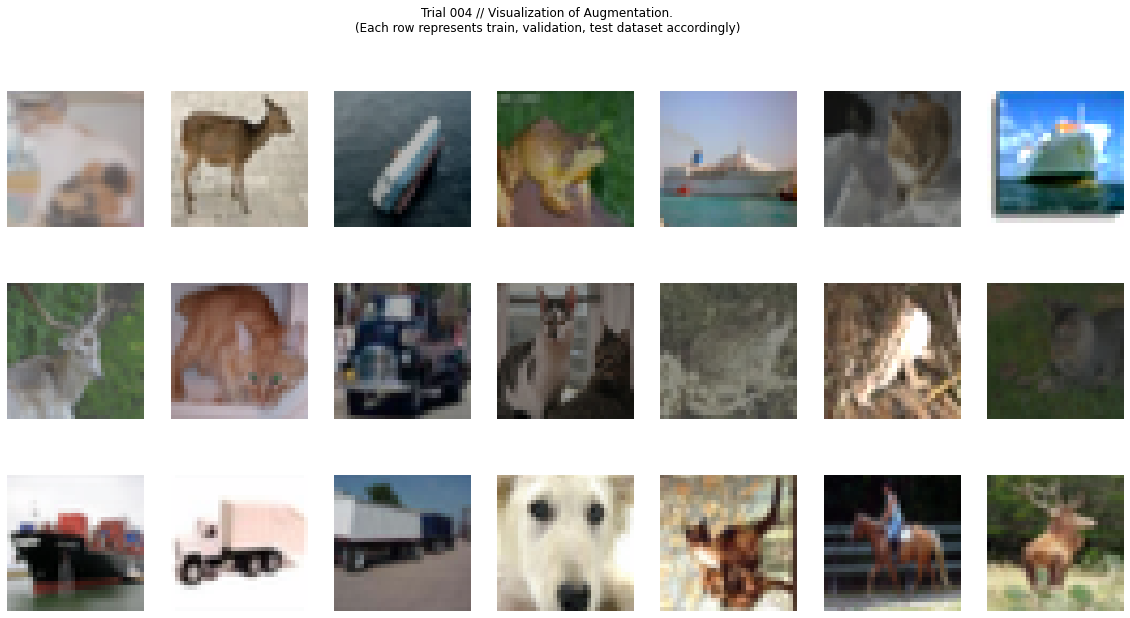

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     

Train: [001] Loss: 1.989, Acc: 27.93% F1(macro): 0.27: 100%|██████████| 312/312 [00:22<00:00, 13.77it/s]
 Val:       Loss: 1.934, Acc: 37.40% F1(macro): 0.36: 100%|██████████| 79/79 [00:02<00:00, 38.08it/s]


Model saved. Current best test f1: 0.362


Train: [002] Loss: 1.640, Acc: 40.98% F1(macro): 0.40: 100%|██████████| 312/312 [00:22<00:00, 13.65it/s]
 Val:       Loss: 1.699, Acc: 40.81% F1(macro): 0.39: 100%|██████████| 79/79 [00:02<00:00, 37.18it/s]


Model saved. Current best test f1: 0.390


Train: [003] Loss: 1.485, Acc: 46.67% F1(macro): 0.46: 100%|██████████| 312/312 [00:22<00:00, 13.74it/s]
 Val:       Loss: 1.398, Acc: 49.65% F1(macro): 0.49: 100%|██████████| 79/79 [00:02<00:00, 37.21it/s]


Model saved. Current best test f1: 0.491


Train: [004] Loss: 1.449, Acc: 48.29% F1(macro): 0.48: 100%|██████████| 312/312 [00:23<00:00, 13.31it/s]
 Val:       Loss: 1.414, Acc: 50.00% F1(macro): 0.50: 100%|██████████| 79/79 [00:02<00:00, 37.87it/s]


Model saved. Current best test f1: 0.498


Train: [005] Loss: 1.314, Acc: 53.15% F1(macro): 0.53: 100%|██████████| 312/312 [00:22<00:00, 13.82it/s]
 Val:       Loss: 1.278, Acc: 54.30% F1(macro): 0.54: 100%|██████████| 79/79 [00:02<00:00, 38.78it/s]


Model saved. Current best test f1: 0.543


Train: [006] Loss: 1.327, Acc: 53.07% F1(macro): 0.53: 100%|██████████| 312/312 [00:23<00:00, 13.55it/s]
 Val:       Loss: 1.203, Acc: 56.27% F1(macro): 0.56: 100%|██████████| 79/79 [00:02<00:00, 38.35it/s]


Model saved. Current best test f1: 0.562


Train: [007] Loss: 1.194, Acc: 57.80% F1(macro): 0.58: 100%|██████████| 312/312 [00:23<00:00, 13.52it/s]
 Val:       Loss: 1.261, Acc: 55.72% F1(macro): 0.55: 100%|██████████| 79/79 [00:02<00:00, 38.38it/s]
Train: [008] Loss: 1.210, Acc: 57.83% F1(macro): 0.58:  68%|██████▊   | 211/312 [00:11<00:07, 14.36it/s]

In [24]:
#load model
with open("./configs/model/mobilenetv3.yaml", "r") as f:
    model_cfg = yaml.load(f, yaml.SafeLoader)
model_cfg['backbone'][-1][-1] = [10]

study = optuna.create_study(direction="maximize", study_name="autoaug", load_if_exists=True)
study.optimize(lambda trial: objective(trial,model_cfg), n_trials=20)